[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/DecisionTree.ipynb)

# Decision tree 
We want implement a decision tree for classification from scratch. For this, first we define a data-structure to represent nodes, then we define a function to pick the best *test* for a node based on a *cost function*. Starting from the root node, we use this test function recursively to find the best split until a *max-depth* is reached. Procedures closely follow our presentation in the class. This implementation is rather involved. You may find it  more difficult to follow compared to KNN implementation. 

In [1]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

### Data structure
we use a binary tree to assign information to the nodes of the decision tree. In particular, the instances associated with that node (`data_indices`) and the test that is used to further split that node, in the case non-leaf nodes (`split_feature, split_value`). Here, we assume each test involves a single feature, and all features are real-valued.

In [2]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        if parent:
            self.depth = parent.depth + 1
            self.num_classes = parent.num_classes
            self.data = parent.data
            self.labels = parent.labels
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)

### Greedy spliting of a node
given a node, we consider all possible feature-value combinations for splitting the data. One such **test** that produces the lowest cost according to a supplied cost function (`cost_fn`) is returned.

In [3]:
def greedy_test(node, cost_fn):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    data_sorted = np.sort(node.data[node.data_indices],0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

### Cost functions

below we implement two cost functions corresponding to misclassification rate and entropy. Try implementing **Gini index**.

In [4]:
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log(class_probs))

we are now ready to implement the classifier:

when to stop splitting?
1. if there are not enough points under the current node (`min_leaf_instances`)
2. if reached maximum depth (`max_depth`)
3. if the decrease in the cost is negligible (not implemented)
Below is the template for the class, next we implement `fit` and `predict` methods.

In [5]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth
        self.root = None
        self.cost_fn = cost_fn
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances
        
    def fit(self, data, labels):
        pass
    
    def predict(self, data_test):
        pass

### Fit
To fit the tree to the data, we call the `fit_tree` method on the `root_node` of the tree. In this method the _best_ test (split) for the current node is found, and the method is recursively called on the left and right child. If the `max_depth` is reached or the number of instances under the current node is below `min_leaf_instances` the node is not split anymore, resulting in a leaf node.

In [6]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    self._fit_tree(self.root)
    return self

def fit_tree(self, node):
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    test = node.data[node.data_indices,split_feature] <= split_value
    node.split_feature = split_feature
    node.split_value = split_value
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    self._fit_tree(left)
    self._fit_tree(right)
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = fit_tree

### New predictions
given a new instance, starting from the `root` of the `DecisionTree` we check to see if the instance falls in the left or right split, and repeat the process with left or right node depending on the test, until we reach a leaf node. The class probabilities of the training data under the leaf is returned.

In [7]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right

        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# Experiments
We conveniently load the dataset from the sklearn collection of datasets

In [8]:
from sklearn import datasets
dataset = datasets.load_iris()
x, y = dataset['data'][:,:2], dataset['target']
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
inds = np.random.permutation(num_instances)
#train-test split)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

next we fit the tree to the training data and predict on the test data. 

accuracy is 72.0.


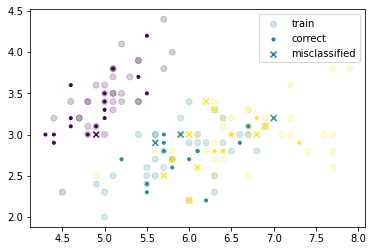

In [9]:
tree = DecisionTree(max_depth=20)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')
#visualization
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

We then plot the *decision boundary*

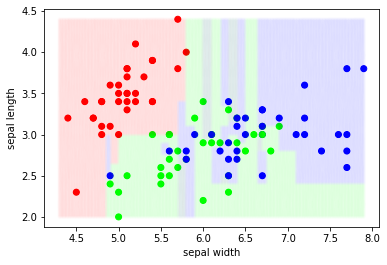

In [11]:
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=200)
y_train_prob = np.zeros((y_train.shape[0], num_classes))
y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
y_prob_all = model.fit(x_train, y_train).predict(x_all)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()